In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Take Random Actions in the Environment
Agent taking random actions are not able to solve the environment

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


### First creating models for both Actor and Critic

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [8]:
class Actor(nn.Module):
    """Actor Model"""
    
    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build the model
        Params
            state_size (int) : Dimension of each state
            action_size (int) : Dimension of each action
            seed (int) : Ranom seed
            fc1 units (int) : number of nodes in first hidden layer
            fc2_units (int) : number of nodes in second hidden layer
            fc3_units (int) : number of nodes in third hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        """Build an actor policy network that map states to actions"""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        return torch.tanh(self.fc3(x))

In [9]:
class Critic(nn.Module):
    """Critic Model"""
    def __init__(self, state_size, action_size, seed, f1_units=400, f2_units=300):
        """Initialize parameters and build the model
        Params
            state_size (int) : Dimension of each state
            action_size (int) : Dimension of each action
            seed (int) : Random seed
            f1_units (int) : number of nodes of first hidden layer
            f2_units (int) : number of nodes of second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.f1 = nn.Linear(state_size, f1_units)
        self.bn1 = nn.BatchNorm1d(f1_units)
        self.f2 = nn.Linear(f1_units+action_size, f2_units)
        self.bn2 = nn.BatchNorm1d(f2_units)
        self.f3 = nn.Linear(f2_units, 1)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.f1.weight.data.uniform_(*hidden_init(self.f1))
        self.f2.weight.data.uniform_(*hidden_init(self.f2))
        self.f3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        """Build a critic value network that maps (state, action) pairs to Q values"""
        xs = F.relu(self.bn1(self.f1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.bn2(self.f2(x)))
        return self.f3(x)

### crearing the agent

In [13]:
import random
import copy
from collections import namedtuple, deque
import torch.optim as optim

In [11]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0  # L2 weight decay
UPDATE_EVERY = 20       # number of steps between every round of updates
N_UPDATES = 10          # number of batches in a single round of updates

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
class Agent():
    """Interacts with the environment and learns from it"""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an agent object
        
        Params
            state_size (int) : dimension of each state
            action_size (int) : dimension of each action
            random_seed (int) : random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random_seed
        
        # Actor network along with its target network setup and actor network optimizer setup
        # target network optimization would be done in seperate way called as soft update
        self.actor_active = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_active.parameters(), lr=LR_ACTOR)
        
        
#         # Critic network along with its target network
        self.critic_active = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_active.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        # Noise process is used in creating exploration policy. In this case Ornstein-Uhlenbeck process is used to create noise
        self.noise = OUNoise(action_size, random_seed)
        
        # Replay Memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        # Initialize time step
        self.t_step = 0
        
    def step_to_learn(self, state, action, reward, next_state, done):
        """Save experience in replay memory and use randomly extracted sample from buffer to learn"""
        # save the experience in buffer
        self.memory.add(state, action, reward, next_state, done)
        
        if self.t_step == 0:
        
            # learn when enough samples are available to be extracted to learn from memory
            if len(self.memory) > BATCH_SIZE:
                for i in range(N_UPDATES):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA)
            
    def get_action_to_take(self, state, add_noise=True):
        """Returns action to take given a state according to learned policy so far"""
    
        state = torch.from_numpy(state).float().to(device)
        self.actor_active.eval()
        with torch.no_grad():
            action = self.actor_active(state).cpu().data.numpy()
        self.actor_active.train()
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
    
    def learn(self, experiences, gamma):
        """
        Update policy and value parameters using batch of experience tuples
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        
        # update the critic
        # Get predicted next-state action using the target actor network
        actions_next = self.actor_target(next_states)
        # Get q value of target action using the critic
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_active(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_active.parameters(), 1)
        self.critic_optimizer.step()
        
        # update the actor
        # Compute actor loss
        actions_pred = self.actor_active(states)
        actor_loss = -self.critic_active(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Update the target networks using soft update
        self.soft_update(self.critic_active, self.critic_target, TAU)
        self.soft_update(self.actor_active, self.actor_target, TAU) 
        
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update the model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [14]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.03, sigma=0.02):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [15]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Train the agent by interacting with the environment

In [16]:
agent = Agent(state_size, action_size, 2)

In [19]:
def train_agent(n_episodes=500, max_t=1000):
    """Train an agent by iterating episodes"""
    checkpoint_name = 'ddpg.pth'
    mean_scores = []
    moving_avgs = []
    scores_window = deque(maxlen=100)
    printed = False
    print_every = 1
    target_score = 30
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        current_state = env_info.vector_observations
        score = np.zeros(len(env_info.agents))
        agent.reset()
        for t in range(max_t):
            action = agent.get_action_to_take(current_state)      # Select an action
            env_info = env.step(action)[brain_name]               # Send the action to the environment
            next_state = env_info.vector_observations           # Get the next state from env after action taken
            reward = env_info.rewards                          # Get the reward received
            done = env_info.local_done                         # See if the episode has finished
            agent.step_to_learn(current_state, action, reward, next_state, done) # make the agent learn
            score += reward
            current_state = next_state
            if np.any(done):
                break                     
        mean_scores.append(np.mean(score))
        # append the mean score in score window
        scores_window.append(mean_scores[-1])       
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} : \tMeanScore: {:.2f}\tMovAvg: {:.2f}'.format(\
                  i_episode, mean_scores[-1], moving_avgs[-1]))
                  
        if moving_avgs[-1] >= target_score and i_episode >= 100 and printed == False:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.2f} over last 100 episodes'.format(\
                                    i_episode, moving_avgs[-1]))
            torch.save(agent.actor_active.state_dict(), checkpoint_name)
            printed = True
    return mean_scores, moving_avgs

In [19]:
# for 256 batch size
scores = train_agent()

Episode 1 : 	MeanScore: 1.49	MovAvg: 1.49
Episode 2 : 	MeanScore: 1.75	MovAvg: 1.62
Episode 3 : 	MeanScore: 1.43	MovAvg: 1.56
Episode 4 : 	MeanScore: 1.77	MovAvg: 1.61
Episode 5 : 	MeanScore: 1.19	MovAvg: 1.53
Episode 6 : 	MeanScore: 0.36	MovAvg: 1.33
Episode 7 : 	MeanScore: 0.28	MovAvg: 1.18
Episode 8 : 	MeanScore: 0.05	MovAvg: 1.04
Episode 9 : 	MeanScore: 0.84	MovAvg: 1.02
Episode 10 : 	MeanScore: 0.00	MovAvg: 0.92
Episode 11 : 	MeanScore: 0.37	MovAvg: 0.87
Episode 12 : 	MeanScore: 0.28	MovAvg: 0.82
Episode 13 : 	MeanScore: 0.08	MovAvg: 0.76
Episode 14 : 	MeanScore: 1.57	MovAvg: 0.82
Episode 15 : 	MeanScore: 0.26	MovAvg: 0.78
Episode 16 : 	MeanScore: 1.72	MovAvg: 0.84
Episode 17 : 	MeanScore: 0.36	MovAvg: 0.81
Episode 18 : 	MeanScore: 2.81	MovAvg: 0.92
Episode 19 : 	MeanScore: 1.09	MovAvg: 0.93
Episode 20 : 	MeanScore: 1.42	MovAvg: 0.96
Episode 21 : 	MeanScore: 1.81	MovAvg: 1.00
Episode 22 : 	MeanScore: 2.24	MovAvg: 1.05
Episode 23 : 	MeanScore: 1.15	MovAvg: 1.06
Episode 24 : 	MeanSc

Episode 183 : 	MeanScore: 35.03	MovAvg: 32.16
Episode 184 : 	MeanScore: 31.52	MovAvg: 32.17
Episode 185 : 	MeanScore: 36.65	MovAvg: 32.30
Episode 186 : 	MeanScore: 30.30	MovAvg: 32.42
Episode 187 : 	MeanScore: 37.69	MovAvg: 32.41
Episode 188 : 	MeanScore: 37.08	MovAvg: 32.48
Episode 189 : 	MeanScore: 15.66	MovAvg: 32.24
Episode 190 : 	MeanScore: 21.21	MovAvg: 32.37
Episode 191 : 	MeanScore: 37.66	MovAvg: 32.38
Episode 192 : 	MeanScore: 38.23	MovAvg: 32.58
Episode 193 : 	MeanScore: 35.83	MovAvg: 32.61
Episode 194 : 	MeanScore: 32.23	MovAvg: 32.61
Episode 195 : 	MeanScore: 37.05	MovAvg: 32.76
Episode 196 : 	MeanScore: 28.29	MovAvg: 32.72
Episode 197 : 	MeanScore: 32.63	MovAvg: 32.80
Episode 198 : 	MeanScore: 33.63	MovAvg: 32.75
Episode 199 : 	MeanScore: 38.63	MovAvg: 32.77
Episode 200 : 	MeanScore: 32.90	MovAvg: 32.74
Episode 201 : 	MeanScore: 22.53	MovAvg: 32.75
Episode 202 : 	MeanScore: 33.97	MovAvg: 32.79
Episode 203 : 	MeanScore: 28.07	MovAvg: 32.73
Episode 204 : 	MeanScore: 32.12	Mo

Episode 362 : 	MeanScore: 31.95	MovAvg: 29.72
Episode 363 : 	MeanScore: 33.95	MovAvg: 29.75
Episode 364 : 	MeanScore: 36.28	MovAvg: 29.80
Episode 365 : 	MeanScore: 23.42	MovAvg: 29.70
Episode 366 : 	MeanScore: 24.34	MovAvg: 29.68
Episode 367 : 	MeanScore: 27.28	MovAvg: 29.62
Episode 368 : 	MeanScore: 33.14	MovAvg: 29.65
Episode 369 : 	MeanScore: 33.83	MovAvg: 29.88
Episode 370 : 	MeanScore: 35.24	MovAvg: 29.90
Episode 371 : 	MeanScore: 30.02	MovAvg: 29.89
Episode 372 : 	MeanScore: 19.38	MovAvg: 29.75
Episode 373 : 	MeanScore: 34.71	MovAvg: 29.82
Episode 374 : 	MeanScore: 30.85	MovAvg: 29.83
Episode 375 : 	MeanScore: 23.68	MovAvg: 29.80
Episode 376 : 	MeanScore: 29.40	MovAvg: 29.76
Episode 377 : 	MeanScore: 29.57	MovAvg: 29.73
Episode 378 : 	MeanScore: 34.78	MovAvg: 29.84
Episode 379 : 	MeanScore: 31.52	MovAvg: 29.85
Episode 380 : 	MeanScore: 37.92	MovAvg: 29.90
Episode 381 : 	MeanScore: 32.59	MovAvg: 29.98
Episode 382 : 	MeanScore: 9.98	MovAvg: 29.74
Episode 383 : 	MeanScore: 38.86	Mov

In [20]:
from matplotlib import pyplot as plt

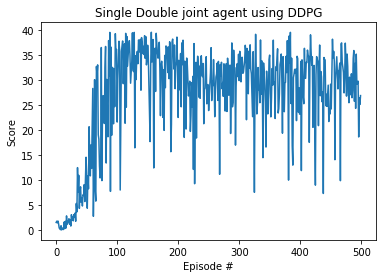

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores[0])), scores[0])
plt.title('Single Double joint agent using DDPG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()